In [1]:
import daspi as dsp
DPI = 120
dsp.__version__

'0.5.0'

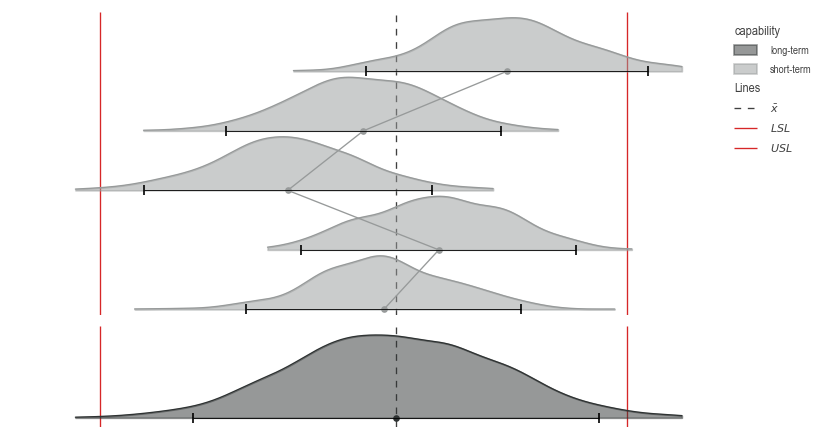

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from typing import Any
from typing import Dict

import seaborn as sns
sns.displot

np.random.seed(3)
N_SAMPLES = 500
HEIGHT = 0.9
means = np.random.random(5)-0.5
df_batch = pd.DataFrame()

for i, mean in enumerate(means):
    pos = i
    data = pd.DataFrame({
        'capability': 'short-term',
        'position': pos,
        'values': stats.norm.rvs(size=N_SAMPLES, loc=mean, scale=0.2)})
    df_batch = pd.concat([df_batch, data], axis=0, ignore_index=True)
df_tot = pd.DataFrame({
    'capability': 'long-term',
    'position': 0,
    'mean': '0',
    'values': df_batch['values']})

chart = dsp.JointChart(
        source=pd.concat([df_batch, df_tot]),
        target='values',
        feature='position',
        hue='capability',
        ncols=1,
        nrows=2,
        height_ratios=[3, 1],
        target_on_y=False,
        sharex=True,
        sharey=False,
        colors=(dsp.DEFAULT.PLOTTING_COLOR, '#979A9A')
    ).stripes(
        stripes=[dsp.StripeLine(
            r'\bar x', df_tot['values'].mean(), orientation='vertical')],
        spec_limits=(-0.75, 0.75),
    ).label(
    )

hueing = chart.charts[0].hueing

def axes_settings(ax) -> None:
    ax.xaxis.set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set(ylim=(-0.1, None), xlim=(-1, 1))

kw_base: Dict[str, Any] = dict(
    feature='position',
    target='values',
    target_on_y=False,
    ax=chart.axes[0, 0],
    color=hueing.categories[1])
kw_kde: Dict[str, Any] = dict(
    height=HEIGHT,
    fill=True,
    ignore_feature=False)
kw_spread: Dict[str, Any] = dict(
    marker='o',
    agreement=4,
)
dsp.CenterLocation(source=df_batch, center_points=False, **kw_base)()
for pos, group in df_batch.groupby('position'):
    dsp.GaussianKDE(source=group, f_base=pos, **(kw_base | kw_kde))()
    dsp.SpreadWidth(source=group, **(kw_base | kw_spread))()

kw_base['ax'] = chart.axes[1, 0]
kw_base['color'] = hueing.categories[0]
dsp.GaussianKDE(source=df_tot, f_base=0, **(kw_base | kw_kde))()
dsp.SpreadWidth(source=df_tot, **(kw_base | kw_spread))()

for ax in chart.axes.flat:
    axes_settings(ax)

In [4]:
pos, data = next(iter(df_batch.groupby('position')))
estimation = dsp.ProcessEstimator(data['values'], -0.75, 0.75)
estimation.Z_lt

2.0395762631892227

In [5]:
estimation = dsp.ProcessEstimator(df_tot['values'], -0.75, 0.75)
estimation.Z

2.281028062704287

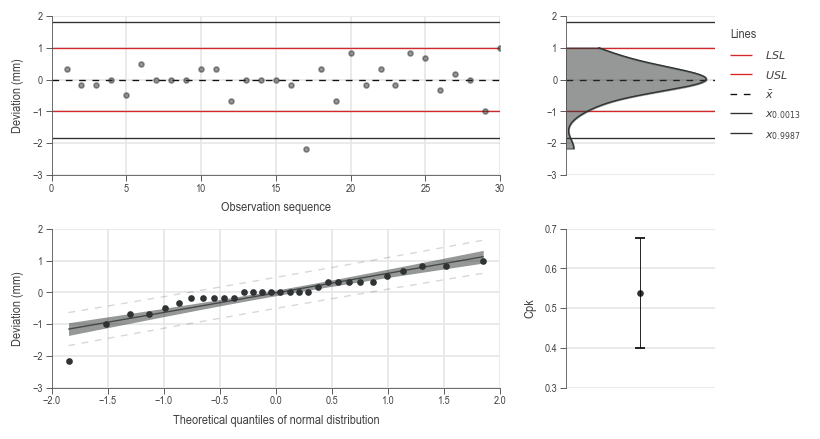

In [3]:
df = dsp.load_dataset('salt_sticks')
spec_limits = tuple(df.loc[0, ['lsl', 'usl']])
target_label = 'Deviation (mm)'

dsp.JointChart(
        source=df,
        target='deviation',
        feature='',
        ncols=2,
        nrows=2,
        width_ratios=[3, 1],
    ).plot(
        dsp.Scatter
    ).plot(
        dsp.GaussianKDE,
        show_density_axis=False,
    ).plot(
        dsp.Probability,
        dist='norm'
    ).plot(
        dsp.CapabilityConfidenceInterval,
        spec_limits=spec_limits,
        n_groups=1,
        kind='cpk'
    ).stripes(
        mean=(
            True, True,
            False, False),
        control_limits=(
            True, True,
            False, False),
        spec_limits=(
            spec_limits, spec_limits,
            (None, None), (None, None)),
    ).label(
        target_label=(
            target_label, '',
            target_label, 'Cpk'),
        feature_label=(
            'Observation sequence', '', 
            'Theoretical quantiles of normal distribution', ''),
    )


In [ ]:
dsp.estimate_capability_confidence(df['deviation'], *spec_limits)

In [ ]:
limits = tuple(df.loc[0, ['lsl', 'usl']])
estimation = dsp.ProcessEstimator(df['deviation'], *limits)
estimation.describe()

In [ ]:
df = dsp.load_dataset('drop_card')
spec_limits = None, float(df.loc[0, 'usl'])
no_limits = (None, None)
target = 'distance'
target_label = 'Distance (mm)'

chart = dsp.JointChart(
        source=df,
        target=target,
        feature='',
        hue='method',
        mosaic=('rr', 'pd', 'ck',),
        height_ratios=[3, 3, 1],
        dodge=(False, False, False, True, True),
        target_on_y=(True, True, False, False, False)
    ).plot(
        dsp.Scatter
    ).plot(
        dsp.Probability,
        dist='norm'
    ).plot(
        dsp.GaussianKDE,
        show_density_axis=False,
    ).plot(
        dsp.CapabilityConfidenceInterval,
        spec_limits=(0, spec_limits[1]),
        n_groups=1,
        kind='cp'
    ).plot(
        dsp.CapabilityConfidenceInterval,
        spec_limits=spec_limits,
        n_groups=1,
        kind='cpk'
    ).stripes(
        mean=False,
        control_limits=(True, False, True, False, False),
        spec_limits=(spec_limits, no_limits, spec_limits, no_limits, no_limits),
    ).label(
        target_label=(target_label, target_label, target_label, 'Cp', 'Cpk'),
        feature_label=(
            'Observation sequence',
            'Theoretical quantiles of normal distribution', '',
            '', ''),
    )

In [ ]:
import numpy as np
import daspi as dsp
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)
x=np.sort(5*np.random.random(100))
df = pd.DataFrame(dict(
    x=x,
    y=np.sin(x) * 3*np.exp(-x) + np.random.normal(0, 0.2, 100)))

model = dsp.Loess(df, 'y', 'x')
options = {
    'tricube': 0.5,
    'gaussian': 0.2,
    'epanechnikov': 0.5}
level = 0.99
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
for (kernel, fraction), ax in zip(options.items(), axs):
    ax.plot(df.x, df.y, label='Original Data', marker='o', lw=0)
    model.fit(kernel=kernel)
    sequence, prediction, lower, upper = model.fitted_line(0.95)
    ax.plot(sequence, prediction, label=f'{kernel.upper()} {fraction=}', lw=1)
    ax.fill_between(sequence, lower, upper, label=f'{level} % CI', alpha=0.2)
    ax.legend(loc='upper right')


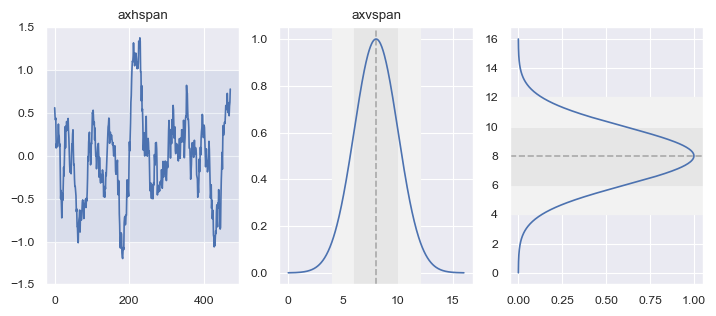

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import daspi as dsp

dsp.style.use('seaborn')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 3))

np.random.seed(19680801)
s = 2.9 * np.convolve(np.random.randn(500), np.ones(30) / 30, mode='valid')
ax1.plot(s)
ax1.axhspan(-1, 1, alpha=0.1)
ax1.set(ylim=(-1.5, 1.5), title="axhspan")

mu = 8
sigma = 2
x = np.linspace(0, 16, 401)
y = np.exp(-((x-mu)**2)/(2*sigma**2))
ax2.axvspan(mu-2*sigma, mu-sigma, color='0.95')
ax2.axvspan(mu-sigma, mu+sigma, color='0.9')
ax2.axvspan(mu+sigma, mu+2*sigma, color='0.95')
ax2.axvline(mu, color='darkgrey', linestyle='--')
ax2.plot(x, y)
ax2.set(title="axvspan")

ax3.axhspan(mu-2*sigma, mu-sigma, color='0.95')
ax3.axhspan(mu-sigma, mu+sigma, color='0.9')
ax3.axhspan(mu+sigma, mu+2*sigma, color='0.95')
ax3.axhline(mu, color='darkgrey', linestyle='--')
ax3.plot(y, x)